In [358]:
import os
import re
import random
import unicodedata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import roc_auc_score, make_scorer
from scripts.data_cleaning import clean_data
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
# from sklearn.
import itertools

In [359]:
import warnings
warnings.filterwarnings('ignore')

In [360]:
train = pd.read_csv("../data/train.csv")
test = pd.read_csv("../data/test.csv")

In [361]:
SEED = 1971

In [362]:
# clean data 
train.set_index("id", inplace=True)
test.set_index("id", inplace=True)
cleaned_train_orig = clean_data(train)
cleaned_test_orig = clean_data(test)

In [363]:
cleaned_train_orig.to_csv("train_cleaned.csv", index=False)

In [366]:
cleaned_train_orig["prod_taken"].value_counts()*100/ len(cleaned_train_orig)

0    85.755231
1    14.244769
Name: prod_taken, dtype: float64

In [132]:
CAT_COL  = cleaned_test_orig.select_dtypes(include=['object', 'category']).columns
NUM_COL = [col for col in cleaned_test_orig.columns if col not in CAT_COL]
CONT_COL = ["age", "duration_of_pitch", "monthly_income"]

In [133]:
def encode_nan_value(X_train, X_test):
    X_train = X_train.copy()
    X_test = X_test.copy()
    
    for col in X_train.columns:
        if X_train[col].isna().sum()>0 or  X_test[col].isna().sum()>0:
            X_train[f'{col}_is_nan'] = X_train[col].isna().astype(int)
            X_test[f'{col}_is_nan'] = X_test[col].isna().astype(int)
            
    return X_train, X_test

def fill_na_num(X_train, X_test, num_coulumns):
    X_train = X_train.copy()
    X_test = X_test.copy()
    for col in num_coulumns:
        if X_train[col].skew() >1:
            X_train[col].fillna(X_train[col].median(), inplace=True)
            X_test[col].fillna(X_train[col].median(), inplace=True)

        else:
            X_train[col].fillna(X_train[col].mean(), inplace=True)
            X_test[col].fillna(X_train[col].mean(), inplace=True)
            
    return X_train, X_test


def outlier_handling(X_train, X_test, columns):
    
    X_train = X_train.copy()
    X_test = X_test.copy()
    
    # first encode outlier, then fill with median
    for col in columns:
        X_train[f"OL_{col}"] = 0
        X_test[f"OL_{col}"] = 0
        # calculate iqr
        q1 = X_train[col].quantile(0.25)
        q3 = X_train[col].quantile(0.75)
        iqr = q3-q1
        Lower_tail = q1 - 1.5 * iqr
        Upper_tail = q3 + 1.5 * iqr
        med = np.median(X_train[col])
        train_index = X_train[(X_train[col] > Upper_tail) | (X_train[col] < Lower_tail)].index
        test_index = X_test[(X_test[col] > Upper_tail) | (X_test[col] < Lower_tail)].index
        
        X_train.loc[train_index, f"OL_{col}"]= 1
        X_test.loc[test_index, f"OL_{col}"]= 1
        
        X_train.loc[train_index, col]= med
        X_test.loc[test_index, col]= med
    

    return X_train, X_test


In [134]:
def binning_cont_col(X_train, X_test, columns): 

    X_train = X_train.copy()
    X_test = X_test.copy()
    
    X = pd.concat([X_train, X_test])
    n_bins = int(np.floor(1 + np.log2(len(X))))
    new_col_names = []
    for col in columns:
        bins = pd.cut(X[col], bins=n_bins, retbins=True)[1]
        # Apply the same bins to the training data
        X[f'{col}_binned'] = pd.cut(X[col], bins=bins, labels=False, include_lowest=True)
        # Apply the same bins to the test data
#         X_test[f'{col}_binned'] = pd.cut(X_test[col], bins=bins, labels=False, include_lowest=True)
#         new_col_names.append(f'{col}_binned')

#     print(X_test.shape, X_test.index)
#     print("here", pd.get_dummies(X_train[new_col_names]))
#     ohe_train = pd.get_dummies(X_train[new_col_names]) #.reset_index(drop=True)
#     ohe_test = pd.get_dummies(X_test[new_col_names]) #.reset_index(drop=True)                    
#     X_train = pd.concat([X_train, ohe_train], ignore_index=True).drop(columns=columns, axis=1)
#     X_test = pd.concat([X_test, ohe_test], ignore_index=True).drop(columns=columns, axis=1)
    X = X.drop(columns=columns, axis=1)
    return X.iloc[:len(X_train)], X.iloc[len(X_train):]

In [352]:
# basic preprocessing

def create_feature(X_train, X_test, num_columns, cat_columns, conti_columns, outlier_removal):
    X_train = X_train.copy()
    X_test = X_test.copy()
    # outlier removal 
    X_train, X_test = outlier_handling(X_train, X_test, outlier_removal)
    # nan encoding 
    X_train, X_test = encode_nan_value(X_train, X_test)
    
    # missing value handling
    # num colif skew is greater than 1, fill with median else mean 
    X_train, X_test = fill_na_num(X_train, X_test, num_columns)

    X_train["m_a"] = X_train["monthly_income"]/ X_train["age"]
    X_test["m_a"] = X_test["monthly_income"]/ X_test["age"]
    
    
    # binning
    X_train, X_test = binning_cont_col(X_train, X_test, conti_columns)
    
    
    # scaler 
    
        
    return X_train, X_test
# cleaned_train_orig[NUM_COL].fillna(cleaned_train_orig[NUM_COL].mean(), inplace=True)

In [353]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from xgboost import XGBClassifier
pipeline = Pipeline( [("model", LogisticRegression())])
# pipeline = Pipeline( [("model", XGBClassifier(subsample=0.5, learning_rate=0.1, max_depth=1, eval_metric="auc"))])

In [354]:
y = cleaned_train_orig['prod_taken']
train_X = cleaned_train_orig[NUM_COL]

In [355]:
train_X.shape, y.shape

((3489, 10), (3489,))

In [357]:

# train_X = train_df.fillna(train_df.mean())
skf = StratifiedKFold(n_splits=5, random_state = SEED, shuffle = True)
scores = []
tr_scores = []

importance_per_fold = {}
for idx, (train_index, valid_index) in enumerate(skf.split(train_X, y)):
    train_df, valid_df, train_y, valid_y = train_X.loc[train_index], train_X.loc[valid_index], y.loc[train_index], y.loc[valid_index]
    print("fold ", idx+1)
    
    X_tr, X_val = create_feature(train_df, valid_df, NUM_COL, CAT_COL, CONT_COL, CONT_COl+["number_of_followups"])
    model = pipeline
    model.fit(X_tr, train_y)
    
    predictions = model.predict_proba(X_val)[:,1]
    scores.append(roc_auc_score(valid_y, predictions))
    train_preds = model.predict_proba(X_tr)[:,1]
    tr_scores.append(roc_auc_score(train_y, train_preds))
    
#     models.append(model)
#     importance_per_fold[f"fold{idx+1}"] = pipeline["model"].feature_importances_#.coef_.reshape(-1)

    print(scores)
print("Train AUC score: {:.4f} Valid AUC score: {:.4f}, STD: {:.4f}".format(
    np.mean(tr_scores), np.mean(scores), np.std(scores)
))

fold  1
[0.6997658862876254]
fold  2
[0.6997658862876254, 0.7696989966555184]
fold  3
[0.6997658862876254, 0.7696989966555184, 0.7296672906021822]
fold  4
[0.6997658862876254, 0.7696989966555184, 0.7296672906021822, 0.7029392421712956]
fold  5
[0.6997658862876254, 0.7696989966555184, 0.7296672906021822, 0.7029392421712956, 0.693186041012128]
Train AUC score: 0.7255 Valid AUC score: 0.7191, STD: 0.0282


In [319]:
# X_tr

In [225]:
X_tr = cleaned_train_orig[NUM_COL]
X_val = cleaned_test_orig[NUM_COL]

X_tr, X_val = create_feature(X_tr, X_val, NUM_COL, CAT_COL, CONT_COL, CONT_COL)

In [226]:
X_tr = pd.DataFrame(StandardScaler().fit_transform(X_tr), columns=X_tr.columns)

In [228]:
# X_tr

In [200]:
from sklearn.manifold import TSNE

n_components = 3
tsne = TSNE(n_components=n_components, perplexity=30, random_state=SEED)
embedding = tsne.fit_transform(X_tr)

column_name = [f"tsne{idx+1}" for idx in range(n_components)]
embedding = pd.DataFrame(embedding, columns=column_name, index=range(len(embedding)))



In [201]:
# target = train_y.copy()
# target = target.reset_index(drop=True)
embedding["target"] = cleaned_train_orig["prod_taken"]

In [202]:
# embedding[target==1]

<AxesSubplot:xlabel='tsne1', ylabel='tsne2'>

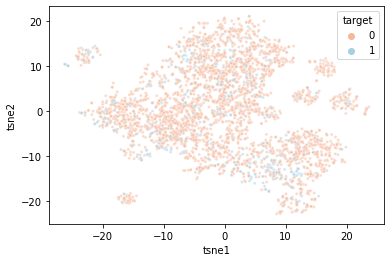

In [203]:
sns.scatterplot(data=embedding, x="tsne1", y="tsne2", hue="target",  marker=".", alpha=0.5, palette='RdBu')

In [204]:
import plotly.express as px
fig = px.scatter_3d(embedding, x='tsne1', y='tsne2', z='tsne3',
              color='target')
fig.show()

# pca

In [205]:
from sklearn.decomposition import PCA
n_components = 3
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X_tr)

# Convert to a DataFrame for easier plotting
column_name = [f"pca{idx+1}" for idx in range(n_components)]

df_pca = pd.DataFrame(X_pca, columns=column_name)
df_pca['target'] = cleaned_train_orig["prod_taken"]

In [206]:
pca.explained_variance_ratio_

array([0.10708174, 0.09861714, 0.09000978])

<AxesSubplot:xlabel='pca3', ylabel='pca1'>

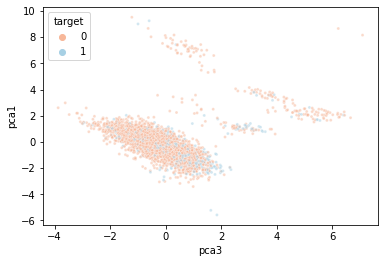

In [214]:
sns.scatterplot(data=df_pca, x="pca3", y="pca1", hue="target",  marker=".", alpha=0.5, palette='RdBu')

In [215]:
import plotly.express as px
fig = px.scatter_3d(df_pca, x='pca1', y='pca2', z='pca3',
              color='target')
fig.show()

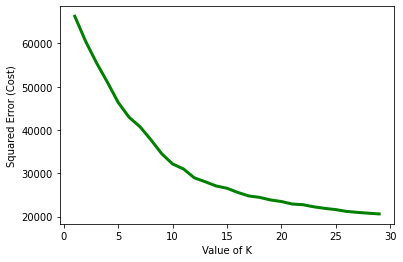

In [193]:
from sklearn.cluster import KMeans # elbow method
cost =[]
for i in range(1, 30):
    KM = KMeans(n_clusters = i)
    KM.fit(X_tr)
     
    # calculates squared error
    # for the clustered points
    cost.append(KM.inertia_)     
 
# plot the cost against K values
plt.plot(range(1, 30), cost, color ='g', linewidth ='3')
plt.xlabel("Value of K")
plt.ylabel("Squared Error (Cost)")
plt.show() # clear the plot

In [211]:
KM = KMeans(n_clusters = 20)
y_cluster = KM.fit_predict(X_tr)

In [235]:
# KM.cluster_centers_

In [217]:
y_cluster.shape

(3489,)

In [219]:
X_cls.shape

(3489, 19)

In [229]:
X_cls = X_tr.copy()
X_cls["cluster"] = y_cluster

In [230]:
X_cls["target"] = y

In [231]:
X_cls["cluster"].value_counts()

5     368
16    357
7     349
12    324
2     282
3     268
15    254
18    234
1     222
13    201
19    162
0     140
14     64
17     58
6      55
9      49
8      38
11     33
10     22
4       9
Name: cluster, dtype: int64

In [232]:
X_cls.groupby("cluster")["target"].mean()

cluster
0     0.450000
1     0.049550
2     0.056738
3     0.059701
4     0.111111
5     0.252717
6     0.127273
7     0.088825
8     0.105263
9     0.020408
10    0.181818
11    0.060606
12    0.157407
13    0.144279
14    0.109375
15    0.161417
16    0.092437
17    0.379310
18    0.094017
19    0.265432
Name: target, dtype: float64

In [320]:
model[0]

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eval_metric='auc', gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=1, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [ ]:
feat_imp = pd.DataFrame(importance_per_fold, index= X_tr.columns)

<AxesSubplot:>

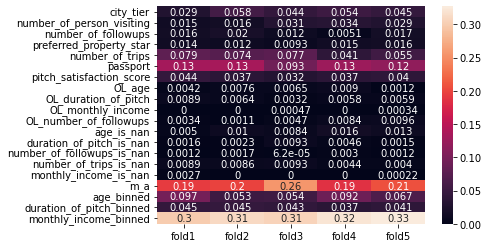

In [194]:
sns.heatmap(feat_imp, annot=True)

<AxesSubplot:>

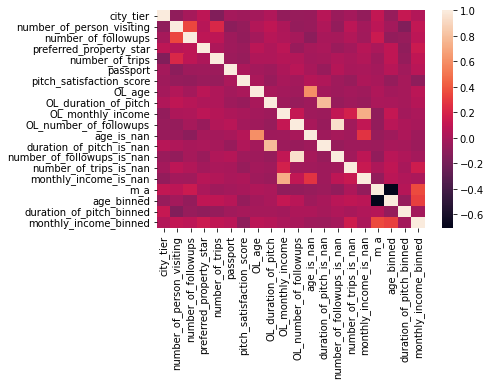

In [215]:
sns.heatmap(X_val.corr())

In [196]:
feat_imp.T.std()

city_tier                     0.011203
number_of_person_visiting     0.008981
number_of_followups           0.005878
preferred_property_star       0.002731
number_of_trips               0.016696
passport                      0.016928
pitch_satisfaction_score      0.004448
OL_age                        0.003086
OL_duration_of_pitch          0.002047
OL_monthly_income             0.000229
OL_number_of_followups        0.003532
age_is_nan                    0.004064
duration_of_pitch_is_nan      0.003278
number_of_followups_is_nan    0.001056
number_of_trips_is_nan        0.002621
monthly_income_is_nan         0.001179
m_a                           0.028160
age_binned                    0.020711
duration_of_pitch_binned      0.003186
monthly_income_binned         0.011325
dtype: float64

In [197]:
# print(train_X.corr()["prod_taken"][["age", "monthly_income", "passport"]])


## partial dependency

In [329]:
from sklearn.inspection import plot_partial_dependence
def plot_dependency(clf, X):
    fig, ax = plt.subplots(figsize=(15, 10))
    ax.set_title("Partial Dependence Plots")
    ax = plot_partial_dependence(
        estimator=clf,
        X=X,
        features=X.columns,
        random_state=5,
        ax=ax,
    )
#     plt.show()
    return ax

In [343]:
from sklearn.ensemble import GradientBoostingClassifier


model1 = LogisticRegression()
model1.fit(X_tr, train_y)

model2 = GradientBoostingClassifier()
model2.fit(X_tr, train_y)

model3 = RandomForestClassifier()
model3.fit(X_tr, train_y)



RandomForestClassifier()

In [344]:
# X_tr.shape
viz_col = X_tr.columns

In [345]:
# viz_col = ['city_tier', 'number_of_person_visiting', 'number_of_followups',
#        'preferred_property_star', 'number_of_trips', 'passport',
#        'pitch_satisfaction_score', 'OL_age', 'OL_duration_of_pitch',
#        'OL_monthly_income', 'OL_number_of_followups', 'age_is_nan', 'number_of_followups_is_nan',
#        'number_of_trips_is_nan', 'monthly_income_is_nan', 'age_binned',
#        'duration_of_pitch_binned', 'monthly_income_binned']

# len(viz_col)

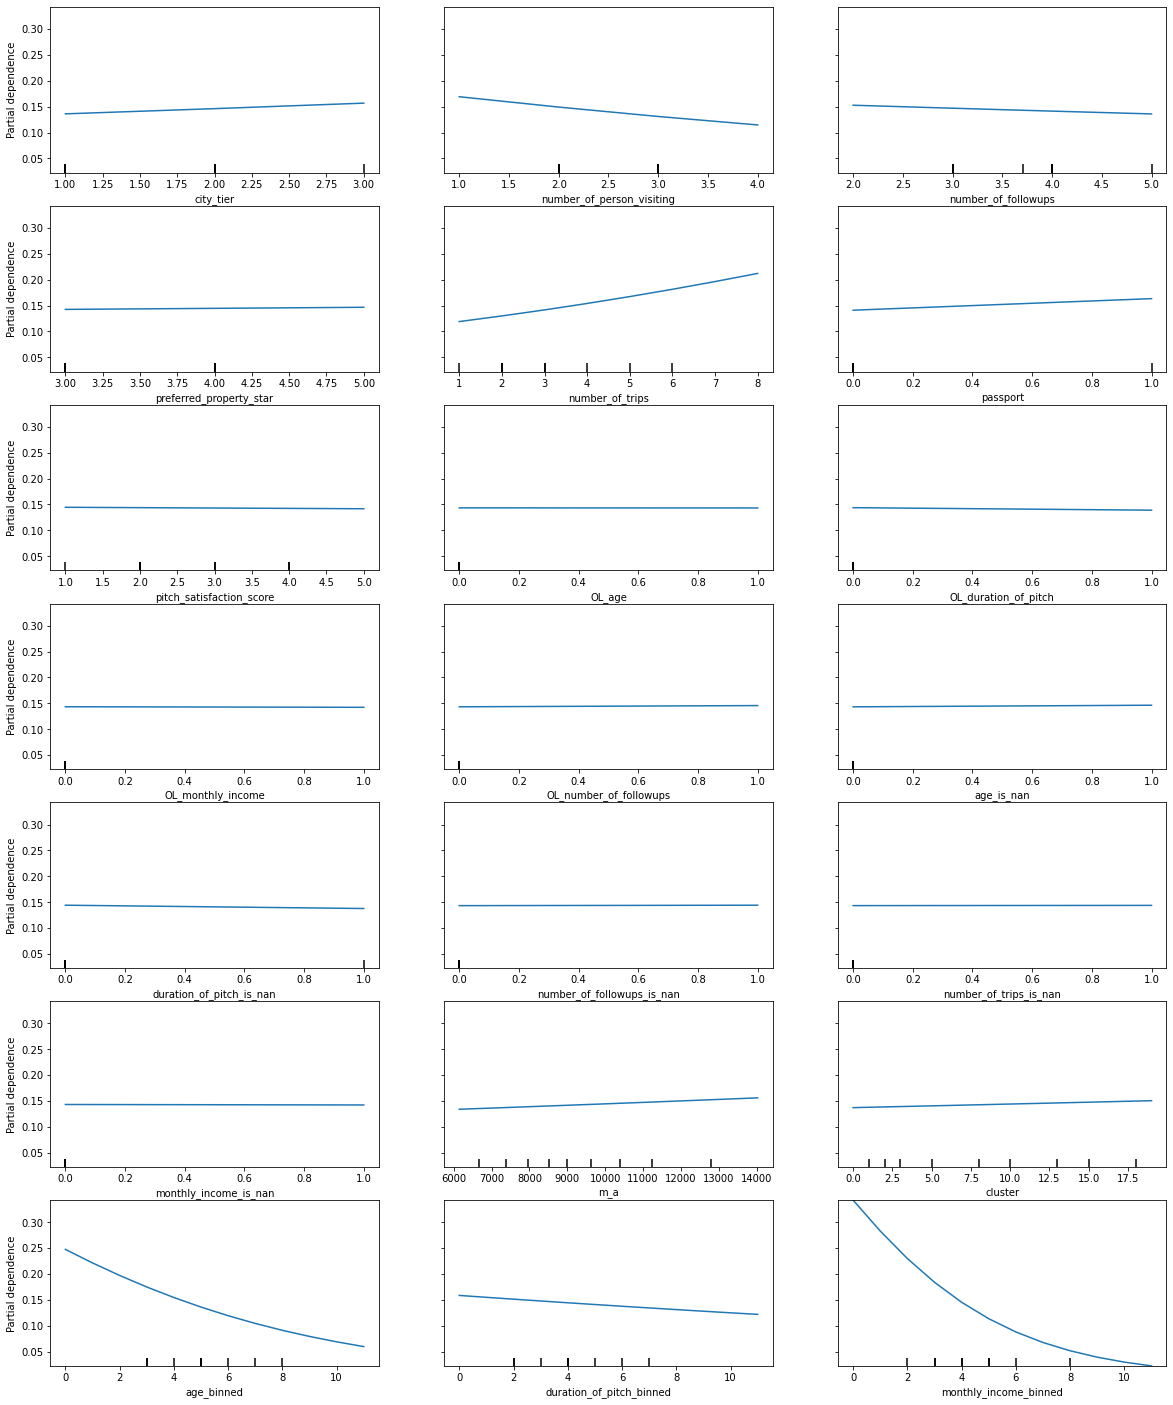

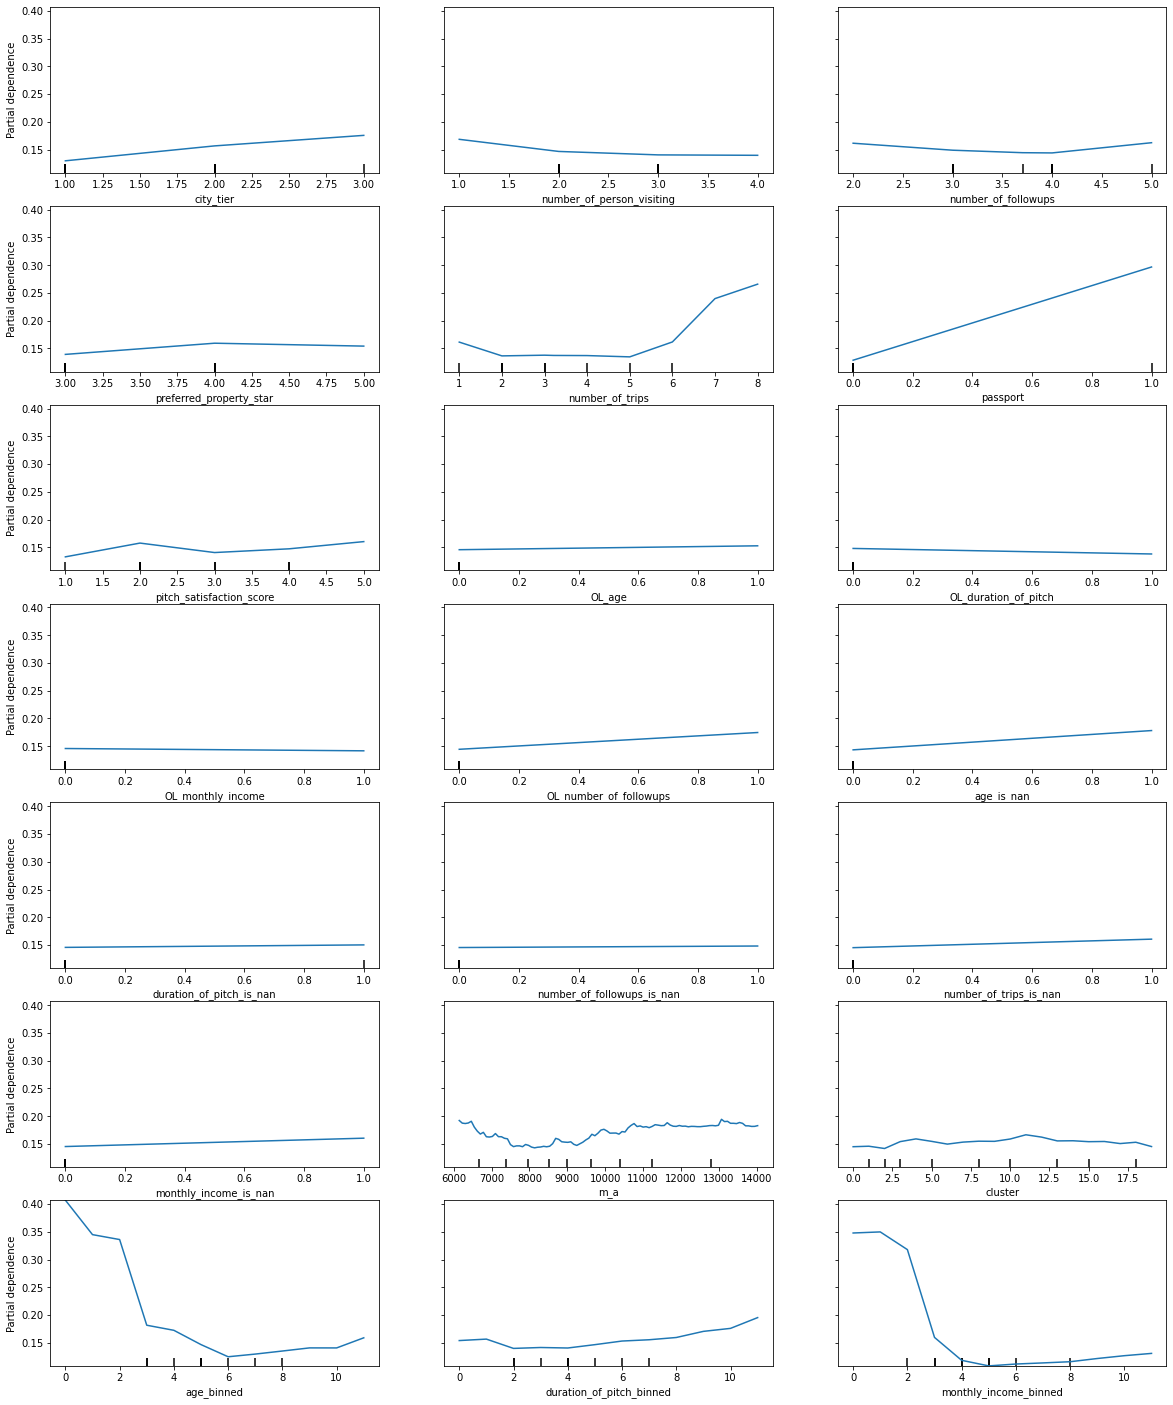

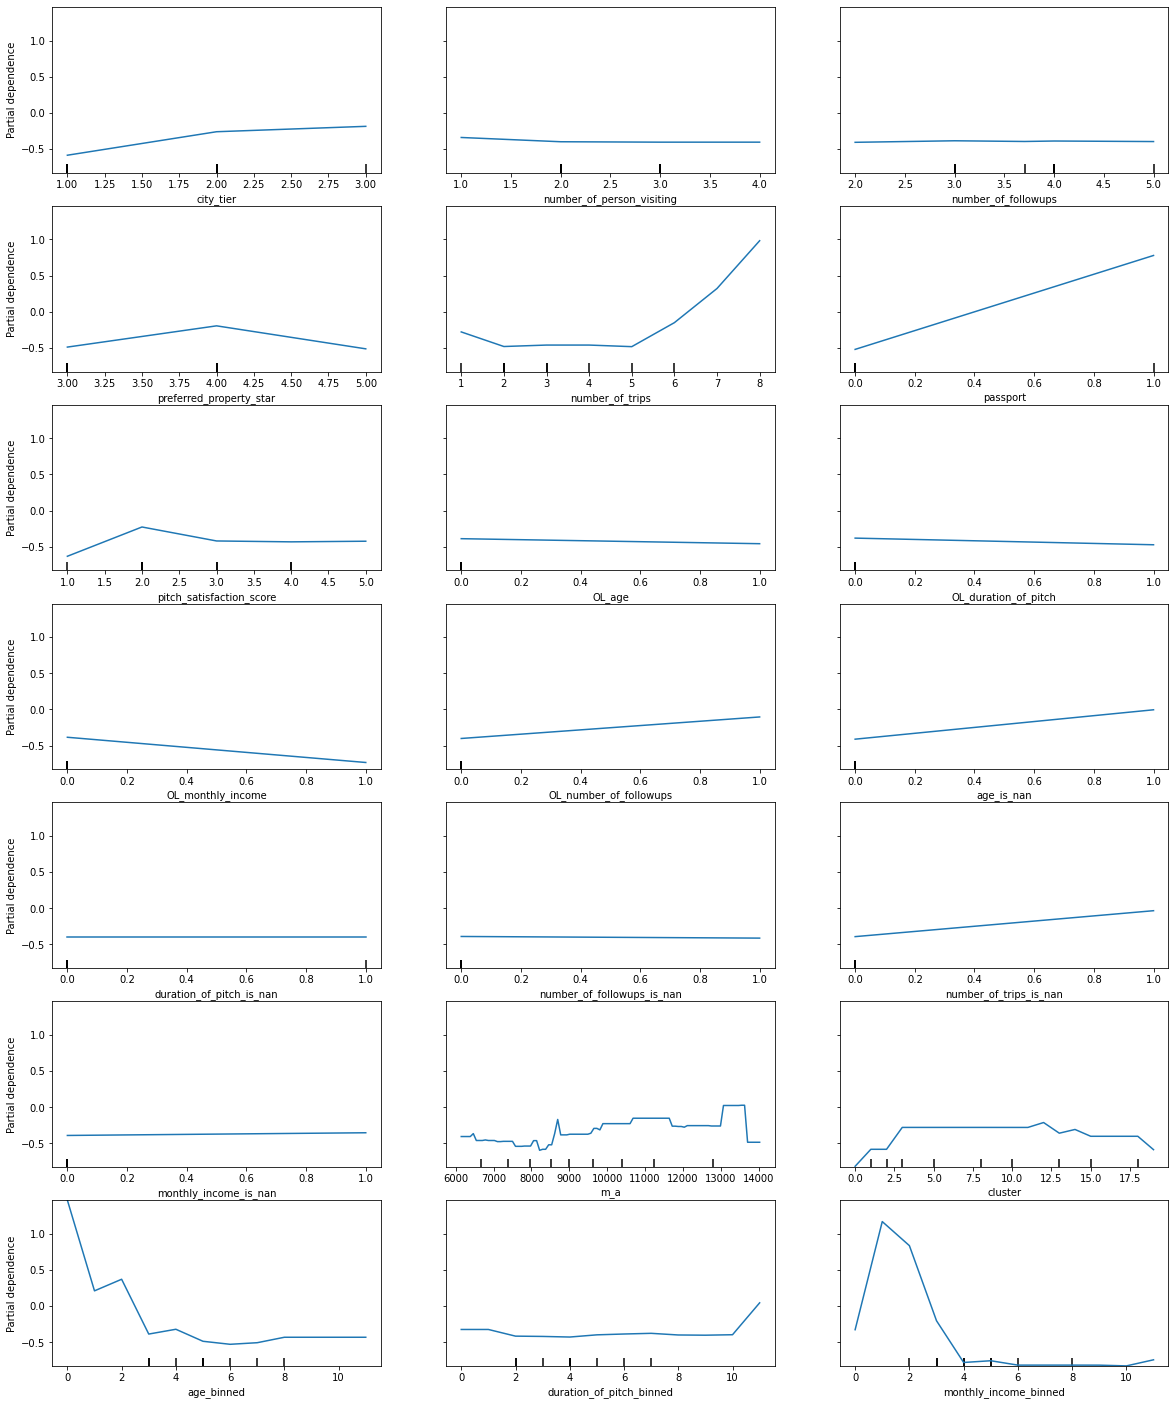

In [346]:
fig, ax = plt.subplots(figsize=(20, 25))
lr_disp = plot_partial_dependence(
        estimator=model1,
        X=X_tr,
        features=viz_col,
        random_state=5,
        ax=ax,
    );
fig, ax = plt.subplots(figsize=(20, 25))
tree_disp = plot_partial_dependence(
        estimator=model3,
        X=X_tr,
        features=viz_col,
        random_state=5,
        ax=ax,
    );
fig, ax = plt.subplots(figsize=(20, 25))
gb_tree_disp = plot_partial_dependence(
        estimator=model2,
        X=X_tr,
        features=viz_col,
        random_state=5,
        ax=ax,
    );


# ax1.legend()
# ax2.legend()

In [334]:
# col = 'age'


In [335]:
# axes.pop(1,9)

ValueError: Expected ax to have 21 axes, got 20

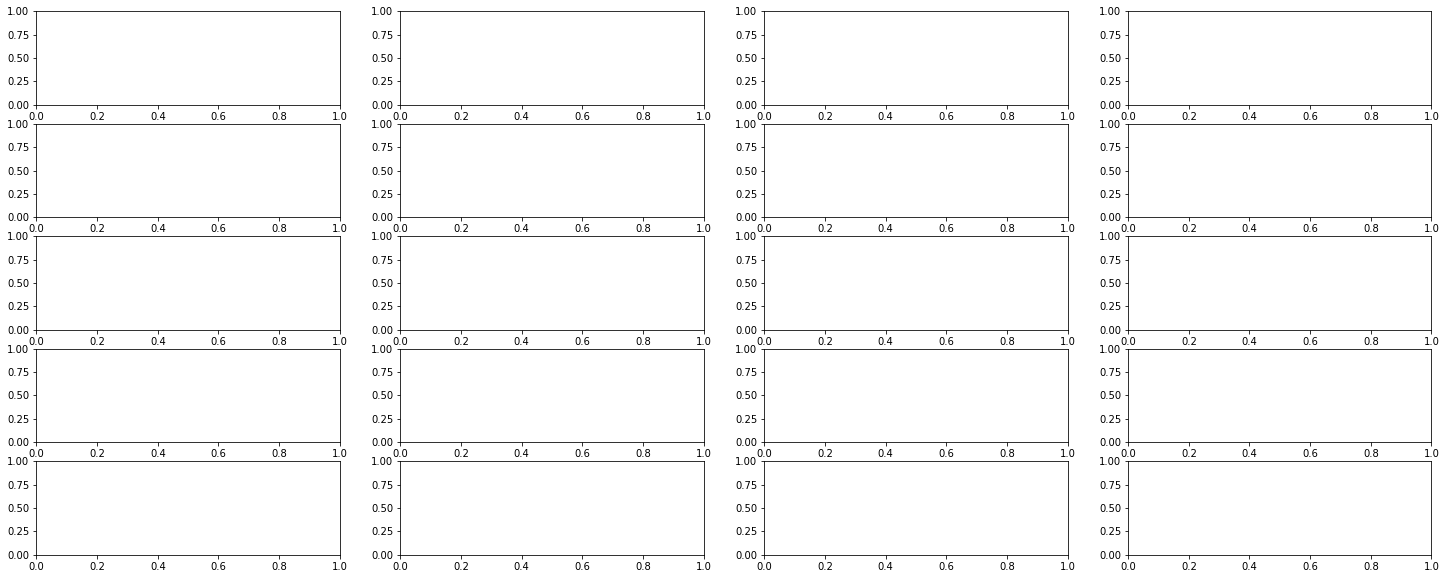

In [336]:
fig, axes = plt.subplots(5, 4, figsize=(25, 10))
tree_disp.plot(ax=axes, line_kw={"label": "Random Forest"})
lr_disp.plot(ax=axes, line_kw={"label": "Logistic Regression",
                                      "color": "red"})
gb_tree_disp.plot(ax=axes, line_kw={"label": "GB tree",
                                      "color": "blue"})

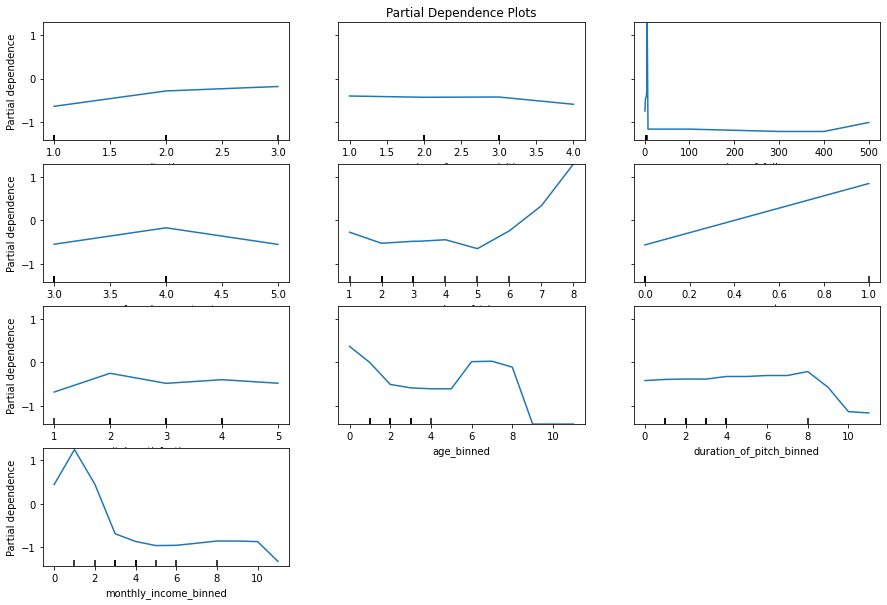

In [282]:
plot_dependency(model2, X_tr)

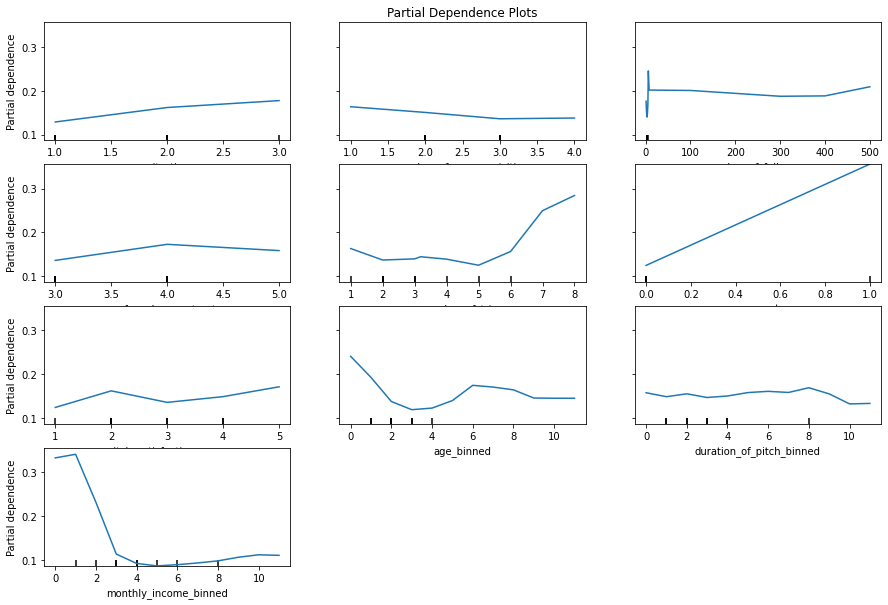

In [245]:
plot_dependency(model3, X_tr)

# train model with only numerical column

In [33]:
# cleaned_train_orig.groupby(comb)["prod_taken"].mean()

In [34]:
    
def get_corr_plot(corr, title="correlations"):
    fig, ax = plt.subplots(figsize=(10,5))
    plt.title(title, fontsize=14)

    mask = np.zeros_like(corr, dtype=bool)
    mask[np.triu_indices_from(mask)] = True
    np.fill_diagonal(mask, False)
    
    # Generate the heatmap including the mask
    heatmap = sns.heatmap(corr,
                        annot=True,
                        annot_kws={"fontsize": 10},
                        fmt='.2f',
                        linewidths=0.5,
                        cmap='RdBu',
                        mask=mask, # the mask has been included here
                        ax=ax)

    # Display our plot
    plt.show()

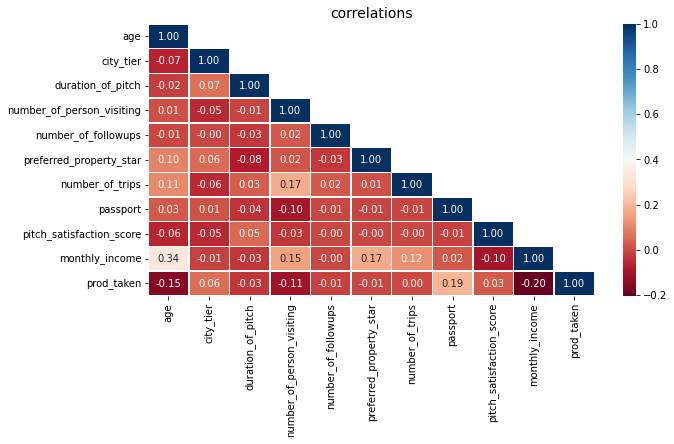

In [35]:
get_corr_plot(cleaned_train_orig.corr())

In [156]:
# cleaned_train_orig.dropna().corr()

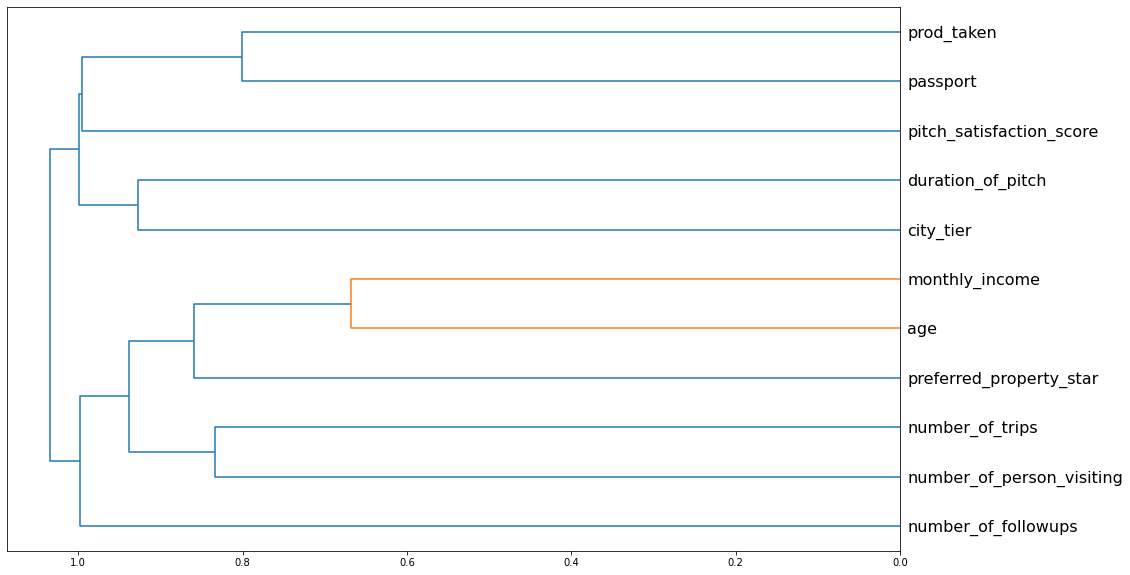

In [177]:
import scipy
from scipy.cluster import hierarchy as hc
plt.figure(figsize=(16,10))
corr = cleaned_train_orig.dropna().corr()
hc.dendrogram(hc.linkage(hc.distance.squareform(1-corr), 
                         method='average'), 
              labels=corr.columns, orientation='left', 
              leaf_font_size=16)
plt.show()

In [160]:
res = df.groupby(["product_pitched", "occupation"])["prod_taken"].agg(['mean', 'count']).reset_index()
res.columns = ["product_pitched",  "occupation", "car_occupation_mean", "car_occupation_count"]

In [161]:
res

,product_pitched,occupation,car_occupation_mean,car_occupation_count
0,basic,Large Business,0.380368,163
1,basic,Salaried,0.280156,257
2,basic,Small Business,0.282540,630
3,deluxe,Large Business,0.024390,41
4,deluxe,Salaried,0.023923,418
5,deluxe,Small Business,0.034404,436
6,king,Large Business,0.000000,7
7,king,Salaried,0.015873,63
8,king,Small Business,0.108696,46
9,standard,Large Business,0.088235,102


In [ ]:
# df.groupby(["product_pitched", "occupation"])["prod_taken"].agg(['mean', 'count']).reset_index()

In [162]:
df.groupby(["car_ownership"])["prod_taken"].agg(['mean', 'count']).reset_index()

,car_ownership,mean,count
0,Car Ownership,0.138820,2831
1,No Car Ownership,0.138667,375


In [10]:
# col_to_idx = {}
# idx_to_col = {}
# for idx, col in enumerate(cleaned_train_orig.columns):
#     col_to_idx[col] = idx
#     idx_to_col[idx] = col
# relationship = hc.linkage(hc.distance.squareform(1-corr), 
#                          method='average')
# relationship_df = pd.DataFrame(relationship, columns= ["col1", "col2", "distance", "n_node"])